In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

In [ ]:
import math
import cv2
from gtts import gTTS

In [ ]:
from moviepy.editor import VideoFileClip, AudioFileClip, CompositeAudioClip
import math
import os

# TRAINING

#DATASET LOADING

In [ ]:
!git clone https://github.com/ultralytics/ultralytics.git

Cloning into 'ultralytics'...
remote: Enumerating objects: 59419, done.
remote: Counting objects: 100% (809/809), done.
remote: Compressing objects: 100% (379/379), done.
remote: Total 59419 (delta 644), reused 443 (delta 430), pack-reused 58610 (from 2)
Receiving objects: 100% (59419/59419), 32.59 MiB | 16.03 MiB/s, done.
Resolving deltas: 100% (44070/44070), done.


In [ ]:
from ultralytics import YOLO

In [ ]:
model = YOLO("yolov8n.pt")

100%|██████████| 6.25M/6.25M [00:00<00:00, 91.9MB/s]


In [ ]:
import torch.nn as nn

In [ ]:
original_head = model.model.model[-1]

In [ ]:
original_head

Detect(
  (cv2): ModuleList(
    (0): Sequential(
      (0): Conv(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): Sequential(
      (0): Conv(
        (conv): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      

In [ ]:
class CustomDetectionHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CustomDetectionHead, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.predict = nn.Conv2d(in_channels, num_classes + 5, kernel_size=1)  # 5 for bbox coords and confidence

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return self.predict(x)

In [ ]:
new_head = CustomDetectionHead(in_channels=80, num_classes=1)

In [ ]:
model.model.model[-1] = nn.Sequential(
    original_head,  # Existing detection head
    new_head        # New detection head
)

In [ ]:
import gc
import torch

gc.collect()

# Free GPU memory (specific to PyTorch)
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()

In [ ]:
model.train(
    data='/content/Tennis-Detection-2/data.yaml',  # Dataset configuration
    epochs=80,
    batch=12,
    mosaic=1.0,
    imgsz=1280
)

Ultralytics 8.3.131 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Tennis-Detection-2/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1280, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, 

100%|██████████| 755k/755k [00:00<00:00, 31.5MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 270/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 167MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1531.9±473.8 MB/s, size: 48.2 KB)


train: Scanning /content/Tennis-Detection-2/train/labels... 1016 images, 7 backgrounds, 0 corrupt: 100%|██████████| 1016/1016 [00:00<00:00, 1795.16it/s]

train: New cache created: /content/Tennis-Detection-2/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 867.4±597.4 MB/s, size: 46.4 KB)


val: Scanning /content/Tennis-Detection-2/valid/labels... 24 images, 1 backgrounds, 0 corrupt: 100%|██████████| 24/24 [00:00<00:00, 736.18it/s]

val: New cache created: /content/Tennis-Detection-2/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00046875), 63 bias(decay=0.0)
Image sizes 1280 train, 1280 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 80 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/80      6.61G     0.4991      271.2      0.264         16       1280: 100%|██████████| 85/85 [01:32<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.77s/it]

                   all         24         23          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/80      5.62G      1.882      156.7     0.7936         10       1280: 100%|██████████| 85/85 [01:06<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all         24         23          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/80      6.96G      4.046      38.23      1.507          9       1280: 100%|██████████| 85/85 [01:06<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

                   all         24         23     0.0473     0.0435     0.0459    0.00484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/80      6.97G      3.506      11.47      1.307          6       1280: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         24         23      0.609      0.348      0.309     0.0737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/80      6.99G      3.177       6.33      1.236         14       1280: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all         24         23      0.595      0.522       0.43      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/80      7.01G      3.056       4.37      1.136         12       1280: 100%|██████████| 85/85 [01:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

                   all         24         23      0.565      0.435      0.439      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/80      7.02G      2.912       3.14      1.094         16       1280: 100%|██████████| 85/85 [01:06<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all         24         23      0.821      0.565      0.657       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/80      7.04G      2.845      2.748      1.104         11       1280: 100%|██████████| 85/85 [01:06<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all         24         23      0.603      0.529      0.605      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/80      7.06G      2.801      2.323      1.094         12       1280: 100%|██████████| 85/85 [01:15<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all         24         23      0.629      0.565      0.563      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/80      7.08G      2.811      2.217      1.086         10       1280: 100%|██████████| 85/85 [01:19<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         24         23      0.717      0.522      0.568      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/80      7.09G      2.715       1.93      1.061          9       1280: 100%|██████████| 85/85 [01:06<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all         24         23      0.692      0.696      0.635      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/80      7.11G      2.662      1.798      1.031          9       1280: 100%|██████████| 85/85 [01:08<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

                   all         24         23      0.532      0.739        0.6       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/80      7.13G      2.625      1.746      1.041         14       1280: 100%|██████████| 85/85 [01:06<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all         24         23      0.585      0.565      0.598       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/80      7.14G      2.585      1.623      1.043          4       1280: 100%|██████████| 85/85 [01:08<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         24         23      0.658      0.753      0.741      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/80      7.16G      2.504      1.536      1.028          8       1280: 100%|██████████| 85/85 [01:06<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         24         23      0.759       0.82      0.776      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/80      7.18G      2.519      1.468      1.021          8       1280: 100%|██████████| 85/85 [01:08<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         24         23       0.71      0.783      0.749       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/80       7.2G      2.542      1.488      1.004         12       1280: 100%|██████████| 85/85 [01:06<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all         24         23      0.678      0.696      0.745      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/80      7.21G      2.462      1.418      1.016         11       1280: 100%|██████████| 85/85 [01:06<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         24         23      0.647      0.783      0.696       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/80      7.23G      2.493      1.414     0.9974          8       1280: 100%|██████████| 85/85 [01:09<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all         24         23      0.814      0.783      0.764        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/80      7.25G      2.444      1.375       1.01          6       1280: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

                   all         24         23       0.73      0.652      0.666      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/80      7.27G      2.507      1.338      1.003         14       1280: 100%|██████████| 85/85 [01:08<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         24         23      0.674      0.739      0.763      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/80      7.28G      2.435      1.291     0.9905         15       1280: 100%|██████████| 85/85 [01:06<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all         24         23       0.84      0.686      0.754      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/80       7.3G      2.431      1.344     0.9961          6       1280: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all         24         23      0.824      0.826      0.829      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/80      7.32G      2.351      1.246     0.9946         11       1280: 100%|██████████| 85/85 [01:06<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         24         23       0.78      0.783      0.764      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/80      7.33G      2.425       1.27     0.9942         12       1280: 100%|██████████| 85/85 [01:06<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

                   all         24         23      0.647      0.798      0.706       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/80      7.35G      2.443      1.263      1.011         11       1280: 100%|██████████| 85/85 [01:06<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all         24         23      0.687      0.765       0.72      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/80      7.37G      2.372      1.221      1.007         17       1280: 100%|██████████| 85/85 [01:08<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all         24         23       0.76      0.696      0.728      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/80      5.83G      2.366      1.232     0.9979          8       1280: 100%|██████████| 85/85 [01:06<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all         24         23      0.823      0.739      0.761      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/80      7.15G       2.41      1.181     0.9953         14       1280: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         24         23      0.748      0.902      0.819      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/80      7.15G      2.376      1.221      1.021         11       1280: 100%|██████████| 85/85 [01:08<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         24         23      0.801      0.783      0.728      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/80      7.15G      2.315      1.151     0.9901         13       1280: 100%|██████████| 85/85 [01:06<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all         24         23      0.735       0.87      0.777      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/80      7.15G      2.357      1.191     0.9942          5       1280: 100%|██████████| 85/85 [01:06<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all         24         23      0.758       0.87      0.793      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/80      7.15G      2.331      1.208     0.9667          7       1280: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all         24         23      0.692       0.88      0.777      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/80      7.15G       2.29      1.139     0.9716         12       1280: 100%|██████████| 85/85 [01:08<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         24         23      0.857      0.783      0.801      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/80      7.15G      2.286      1.117      0.972         15       1280: 100%|██████████| 85/85 [01:09<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all         24         23      0.686      0.855      0.751      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/80      7.15G      2.308      1.134     0.9753          9       1280: 100%|██████████| 85/85 [01:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

                   all         24         23      0.763      0.826      0.802      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/80      7.15G      2.268      1.128     0.9638         10       1280: 100%|██████████| 85/85 [01:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all         24         23      0.863      0.821      0.848      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/80      7.15G      2.255      1.132     0.9552         17       1280: 100%|██████████| 85/85 [01:06<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         24         23      0.832      0.862      0.813      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/80      7.15G      2.286      1.087     0.9999          9       1280: 100%|██████████| 85/85 [01:06<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

                   all         24         23      0.804      0.826      0.829      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/80      7.15G      2.291       1.06     0.9749         10       1280: 100%|██████████| 85/85 [01:08<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all         24         23      0.892      0.913      0.856      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/80      7.16G      2.263      1.118     0.9623         13       1280: 100%|██████████| 85/85 [01:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all         24         23      0.733       0.87      0.798      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/80      7.18G      2.291      1.096     0.9817          9       1280: 100%|██████████| 85/85 [01:06<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

                   all         24         23      0.816      0.771      0.732      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/80       7.2G       2.28      1.098     0.9585          9       1280: 100%|██████████| 85/85 [01:06<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all         24         23      0.669      0.826      0.732       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/80      7.21G      2.236      1.083     0.9683         13       1280: 100%|██████████| 85/85 [01:08<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all         24         23      0.847      0.783      0.776      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/80      7.23G      2.319      1.154      1.002         11       1280: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         24         23      0.872       0.87      0.852      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/80      7.25G      2.206      1.041     0.9718         10       1280: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all         24         23      0.806      0.903      0.817      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/80      7.27G      2.268      1.055     0.9663          8       1280: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all         24         23      0.743      0.882      0.812      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/80      7.28G      2.234       1.07     0.9568         16       1280: 100%|██████████| 85/85 [01:08<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all         24         23      0.801       0.87      0.842      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/80       7.3G      2.166      1.045     0.9611          7       1280: 100%|██████████| 85/85 [01:09<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         24         23      0.813      0.826      0.766      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/80      7.32G      2.217      1.081     0.9727          5       1280: 100%|██████████| 85/85 [01:08<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         24         23      0.831      0.857      0.816      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/80      7.33G      2.219      1.066     0.9674          4       1280: 100%|██████████| 85/85 [01:08<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all         24         23        0.8      0.871       0.84      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/80      7.35G      2.182       1.05     0.9465          7       1280: 100%|██████████| 85/85 [01:06<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all         24         23      0.821      0.913      0.842      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/80      7.37G      2.173      1.049     0.9552         10       1280: 100%|██████████| 85/85 [01:06<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         24         23      0.852       0.87      0.835      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/80      5.85G      2.202       1.05     0.9588          8       1280: 100%|██████████| 85/85 [01:04<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

                   all         24         23      0.902       0.87      0.862      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/80      7.16G      2.188       1.03     0.9447         10       1280: 100%|██████████| 85/85 [01:06<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         24         23      0.803      0.913      0.827      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/80      7.16G      2.196      1.014     0.9477          3       1280: 100%|██████████| 85/85 [01:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all         24         23      0.867      0.826      0.842      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/80      7.16G      2.206      1.032     0.9673         12       1280: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all         24         23      0.816      0.913      0.854      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/80      7.16G      2.115      1.013     0.9475         11       1280: 100%|██████████| 85/85 [01:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         24         23      0.762      0.826      0.826       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/80      7.16G      2.125     0.9941     0.9658          5       1280: 100%|██████████| 85/85 [01:05<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

                   all         24         23      0.828      0.836      0.819      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/80      7.16G      2.144      1.013      0.964         18       1280:  96%|█████████▋| 82/85 [01:05<00:02,  1.27it/s]

[Errno 2] No such file or directory: '{HOME}'
/content


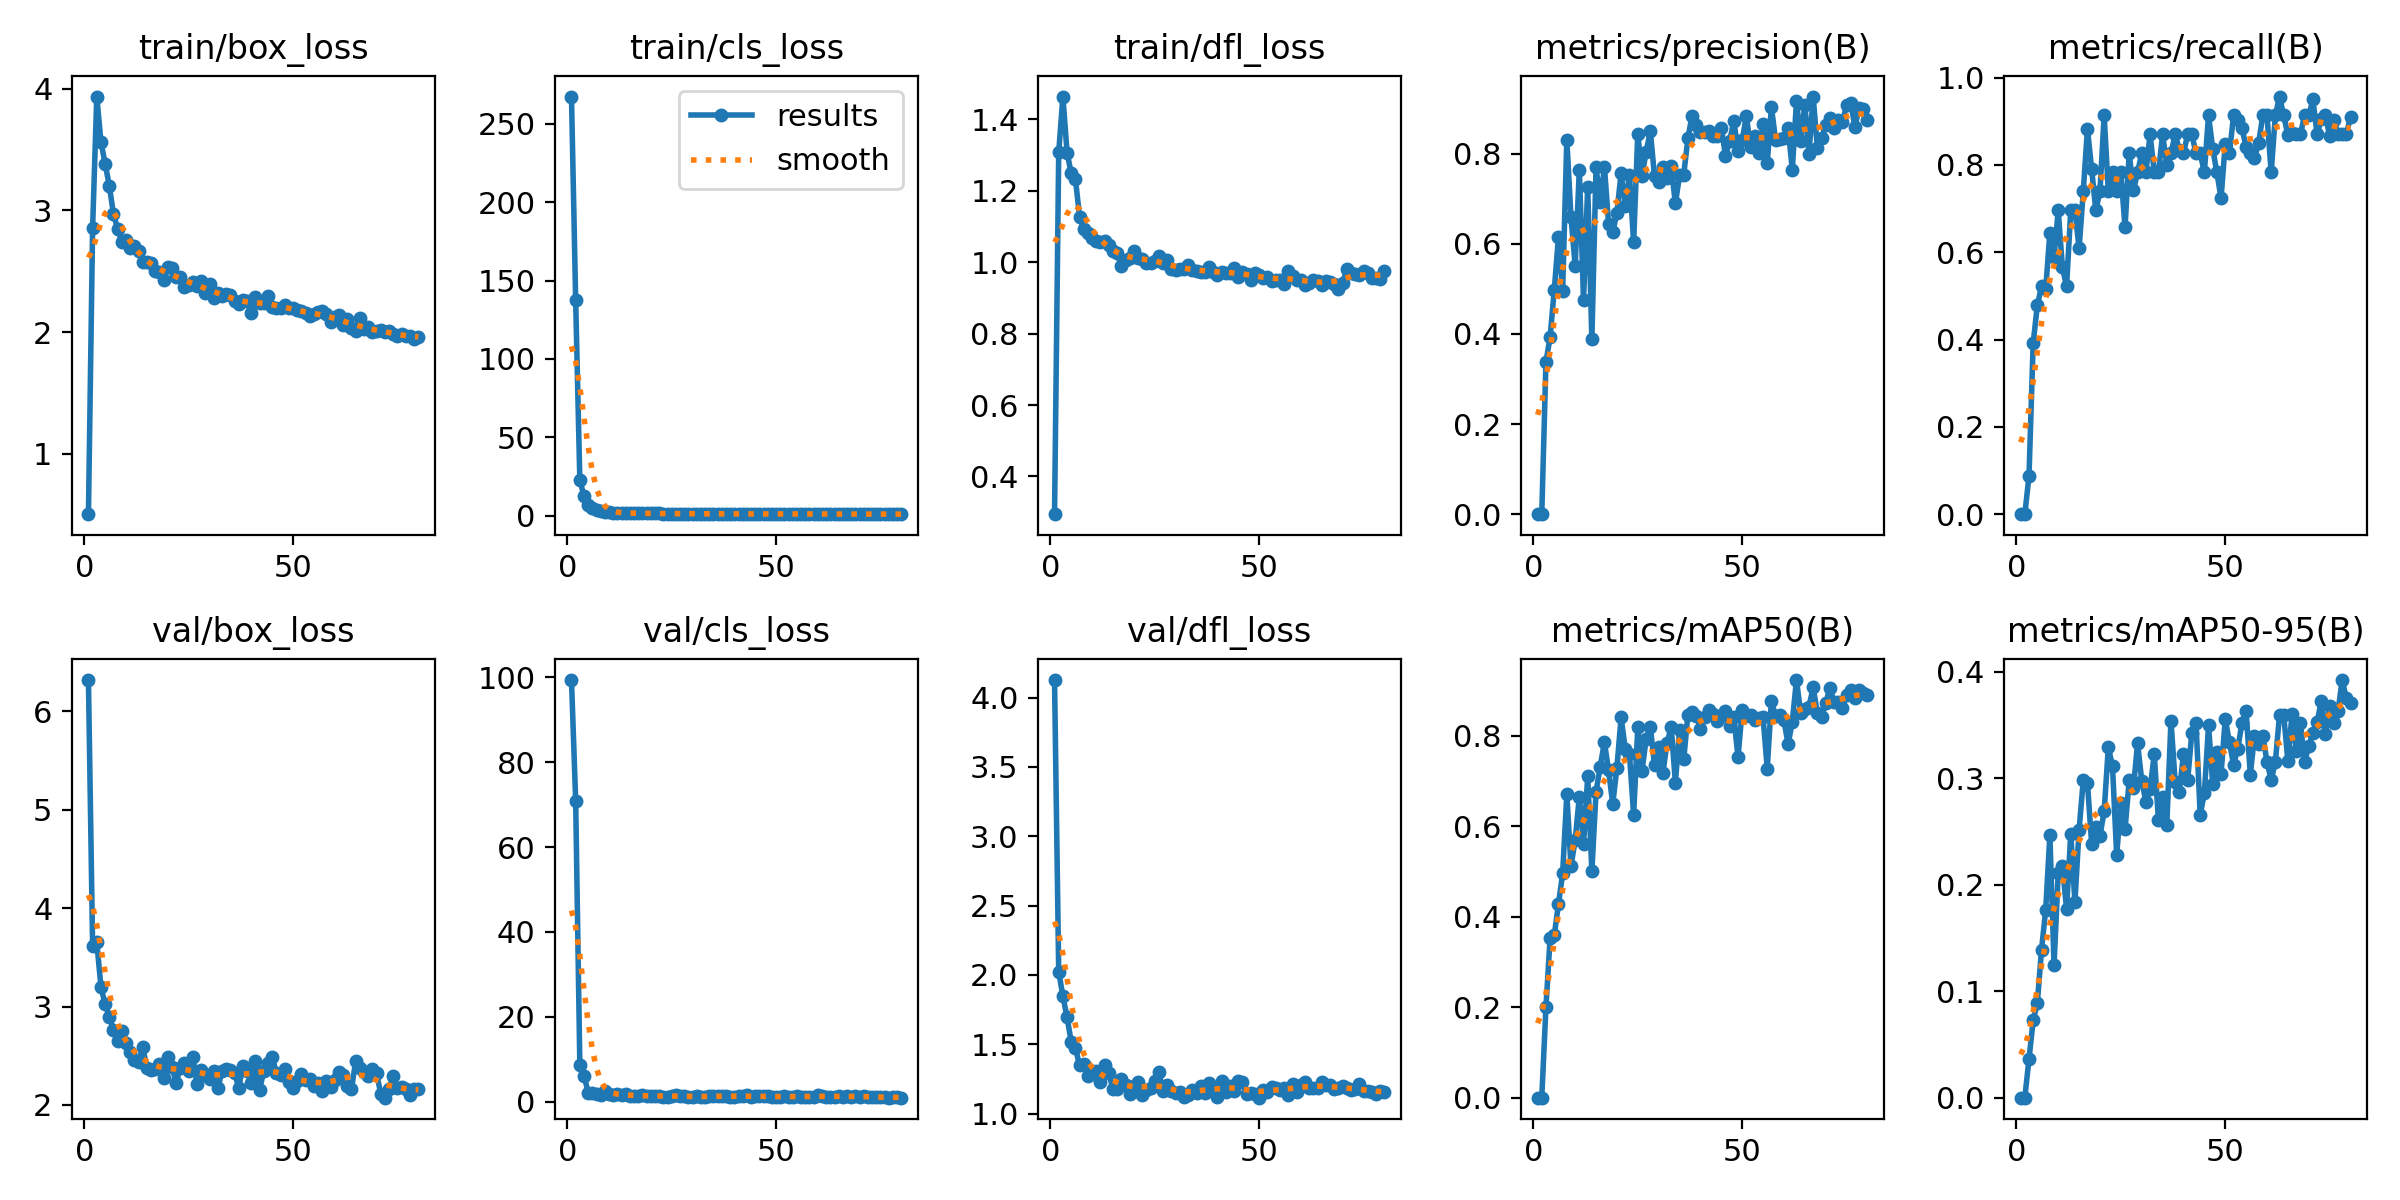

In [ ]:
from IPython.display import Image # Import the Image class

%cd {HOME}
Image(filename=f'/content/runs/detect/train2/results.png', width=600)

**# YOLO WITH SAHI**

# ONLY YOLO AND LLM

In [ ]:
# Load language model
model_id = "openchat/openchat-3.5-0106"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto", torch_dtype="auto")
generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

def generate_commentary(speed_window, start_frame, end_frame):
    prompt = f"""
You're a football match commentator.
Analyze the ball's speed between frames {start_frame} and {end_frame}: {speed_window}.
Generate short, energetic sports commentary."""
    result = generator(prompt, max_new_tokens=60, do_sample=True, temperature=0.8)
    commentary = result[0]['generated_text'].split(prompt)[-1].strip()
    return commentary

def text_to_audio(text, filename="commentary.mp3"):
    tts = gTTS(text=text, lang="en")
    tts.save(filename)

def add_audio_to_video(video_path, audio_events, output_path):
    video = VideoFileClip(video_path)
    clips = [video.audio] if video.audio else []

    for audio_file, start_time in audio_events:
        audio = AudioFileClip(audio_file).set_start(start_time)
        clips.append(audio)

    final_audio = CompositeAudioClip(clips)
    final_video = video.set_audio(final_audio)
    final_video.write_videofile(output_path, codec="libx264", audio_codec="aac")

# ---------------------- Video + YOLO + Commentary ----------------------

video_path = "/content/0405 - Trim.mp4"
temp_video_path = "new_video.mp4"
final_output_path = "final_output.mp4"

model = YOLO("/content/runs/detect/train2/weights/best.pt")

cap = cv2.VideoCapture(video_path)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
time_per_frame = 1 / fps
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(temp_video_path, fourcc, fps, (frame_width, frame_height))

previous_center = None
pixel_to_meter = 0.05
speeds = []
frame_count = 0
window_size = 30  # ≈ 1 second
audio_events = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    results = model(frame, conf=0.3)

    for result in results[0].boxes.data:
        x1, y1, x2, y2 = map(int, result[:4].tolist())
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2

        if previous_center:
            prev_x, prev_y = previous_center
            distance_pixels = math.sqrt((center_x - prev_x) ** 2 + (center_y - prev_y) ** 2)
            distance_meters = distance_pixels * pixel_to_meter
            speed = (distance_meters / time_per_frame) * 3.6
        else:
            speed = 0
        speeds.append(speed)
        previous_center = (center_x, center_y)

        # Draw
        radius = max((x2 - x1) // 2, (y2 - y1) // 2)
        cv2.circle(frame, (center_x, center_y), radius, (0, 0, 255), 1)
        cv2.putText(frame, f"Speed: {speed:.2f} km/h", (center_x, center_y - radius - 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # Commentary generation
    if frame_count % window_size == 0:
        start = frame_count - window_size
        end = frame_count
        speed_window = speeds[start:end]
        commentary_text = generate_commentary(speed_window, start, end)
        print(f"[{start}-{end}] {commentary_text}")

        audio_filename = f"commentary_{start}_{end}.mp3"
        text_to_audio(commentary_text, filename=audio_filename)
        start_time_sec = start / fps
        audio_events.append((audio_filename, start_time_sec))

    out.write(frame)

cap.release()
out.release()
cv2.destroyAllWindows()

# ---------------------- Add Audio to Final Video ----------------------
add_audio_to_video(temp_video_path, audio_events, final_output_path)

# Clean up temp audio
for f, _ in audio_events:
    os.remove(f)

print(f"✅ Final video saved to: {final_output_path}")


0: 736x1280 (no detections), 12.7ms
Speed: 4.7ms preprocess, 12.7ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 (no detections), 12.2ms
Speed: 5.7ms preprocess, 12.2ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 (no detections), 12.2ms
Speed: 5.1ms preprocess, 12.2ms inference, 0.7ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 (no detections), 12.2ms
Speed: 4.6ms preprocess, 12.2ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 (no detections), 12.2ms
Speed: 4.2ms preprocess, 12.2ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 (no detections), 12.2ms
Speed: 4.9ms preprocess, 12.2ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 tennis, 12.2ms
Speed: 4.3ms preprocess, 12.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 (no detections), 12.2ms
Speed: 4.3ms preprocess, 

error: OpenCV(4.10.0) /io/opencv/modules/highgui/src/window.cpp:1295: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'
